Copyright 2020 The "What Can I do Here? A Theory of Affordances In Reinforcement Learning" Authors. All rights reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [0]:
%tensorflow_version 2.x
%pylab inline

# System imports
import copy
import dataclasses
import enum
import itertools
import numpy as np
import operator
import random
import time
from typing import Optional, List, Tuple, Any, Dict, Union, Callable


# Library imports.
from google.colab import files
from matplotlib import colors
import matplotlib.animation as animation
import matplotlib.pylab as plt
import tensorflow as tf

import tensorflow_probability as tfp

Populating the interactive namespace from numpy and matplotlib


# Environment Specification

In [0]:
#@title Point Class
@dataclasses.dataclass(order=True, frozen=True)
class Point:
  """A class representing a point in 2D space.

  Comes with some convenience functions.
  """
  x: float
  y: float

  def sum(self):
    return self.x + self.y

  def l2norm(self):
    """Computes the L2 norm of the point."""
    return np.sqrt(self.x * self.x + self.y * self.y)

  def __add__(self, other: 'Point'):
    return Point(self.x + other.x, self.y + other.y)

  def __sub__(self, other: 'Point'):
    return Point(self.x - other.x, self.y - other.y)

  def normal_sample_around(self, scale: float):
    """Samples a point around the current point based on some noise."""
    new_coords = np.random.normal(dataclasses.astuple(self), scale)
    new_coords = new_coords.astype(np.float32)
    return Point(*new_coords)

  def is_close_to(self, other: 'Point', diff: float = 1e-4):
    """Determines if one point is close to another."""
    point_diff =  self - other
    if abs(point_diff.x) < diff and abs(point_diff.y) < diff:
      return True
    else:
      return False

# Test the points.
z1 = Point(0.4, 0.1)
assert z1.is_close_to(z1)
assert z1.is_close_to(Point(0.5, 0.0), 1.0)
assert not z1.is_close_to(Point(5.0, 0.0), 1.0)
z2 = Point(0.1, 0.1)
z3 = z1 - z2
assert isinstance(z3, Point)
assert z3.is_close_to(Point(0.3, 0.0))
assert isinstance(z3.normal_sample_around(0.1), Point)

class Force(Point):
  pass


# # Intersection code.
# See Sedgewick, Robert, and Kevin Wayne. Algorithms. , 2011.
# Chapter 6.1 on Geometric Primitives
# https://algs4.cs.princeton.edu/91primitives/
def _check_counter_clockwise(a: Point, b: Point, c: Point):
  """Checks if 3 points are counter clockwise to each other."""
  slope_AB_numerator = (b.y - a.y)
  slope_AB_denominator = (b.x - a.x)
  slope_AC_numerator = (c.y - a.y)
  slope_AC_denominator = (c.x - a.x)
  return (slope_AC_numerator * slope_AB_denominator >= \
          slope_AB_numerator * slope_AC_denominator)

def intersect(segment_1: Tuple[Point, Point], segment_2: Tuple[Point, Point]):
  """Checks if two line segments intersect."""
  a, b = segment_1
  c, d = segment_2

  # Checking if there is an intersection is equivalent to:
  # Exactly one counter clockwise path to D (from A or B) via C.
  AC_ccw_CD = _check_counter_clockwise(a, c, d)
  BC_ccw_CD = _check_counter_clockwise(b, c, d)
  toD_via_C = AC_ccw_CD != BC_ccw_CD

  # AND
  # Exactly one counterclockwise path from A (to C or D) via B.
  AB_ccw_BC = _check_counter_clockwise(a, b, c)
  AB_ccw_BD = _check_counter_clockwise(a, b, d)

  fromA_via_B = AB_ccw_BC != AB_ccw_BD

  return toD_via_C and fromA_via_B

# Some simple tests to ensure everything is working.
assert not intersect((Point(1, 0), Point(1, 1)), (Point(0,0), Point(0, 1))), \
  'Parallel lines detected as intersecting.'
assert not intersect((Point(0, 0), Point(1, 0)), (Point(0,1), Point(1, 1))), \
  'Parallel lines detected as intersecting.'
assert intersect((Point(3, 5), Point(1, 1)), (Point(2, 2), Point(0, 1))), \
  'Lines that intersect not detected.'
assert not intersect((Point(0, 0), Point(2, 2)), (Point(3, 3), Point(5, 1))), \
  'Lines that do not intersect detected as intersecting'
assert intersect((Point(0, .5), Point(0, -.5)), (Point(.5, 0), Point(-.5, 0.))), \
  'Lines that intersect not detected.'

In [0]:
#@title ContinuousWorld environment.

class ContinuousWorld(object):
  r"""The ContinuousWorld Environment.

  An agent can be anywhere in the grid. The agent provides Forces to move. When
  the agent provides a force, it is applied and the final position is jittered.

  When the agent is reset, its location is drawn from a global start position
  given by `drift_between`. This start position is non-stationary and drifts
  toward the target start position as the environment resets with the speed
  `drift_speed`.

  For example the start position is (0., 0.). After reseting once, the start
  positon might drift toward (0.5, 0.5). After resetting again it may drift
  again to (0., 0.). This happens smoothly according to the drifting speed.

  Walls can be specified in this environment. Detection works by checking if the
  agents action forces it to go in a direction which collides with a wall.
  """

  def __init__(
      self,
      size: float,
      wall_pairs: Optional[List[Tuple[Point, Point]]] = None,
      drift_between: Optional[List[Tuple[Point, Point]]] = None,
      movement_noise: float = 0.1,
      seed: int = 1,
      drift_speed: float = 0.5,
      reset_noise: Optional[float] = None,
      max_episode_length: int = 10,
      max_action_force: float = 0.5,
      verbose_reset: bool = False
      ):
    """Initializes the Continuous World Environment.

    Args:
      size: The size of the world.
      wall_pairs: A list of tuple of points representing the start and end
        positions of the wall.
      drift_between: A list of tuple of points representing how the starting
        distrubiton should change. If None, it will drift between the four
        corners of the room.
      movement_noise: The noise around each position after movement.
      seed: The seed for the random number generator.
      drift_speed: How quickly to move in the drift direction.
      reset_noise: The noise around the reset position. Defaults to
        movement_noise if not specified.
      max_episode_length: The maximum length of the episode before resetting.
      max_action_force: If using random_step() this will be the maximum random
        force applied in the x and y direction.
      verbose_reset: Prints out every time the global starting position is
        reset.
    """
    self._size = size
    self._wall_pairs = wall_pairs or []
    self._verbose_reset = verbose_reset

    # Points to drift the start position between.
    if drift_between is None:
      self._drift_between = (
          Point((1/4) * size, (1/4) * size),
          Point((1/4) * size, (3/4) * size),
          Point((3/4) * size, (1/4) * size),
          Point((3/4) * size, (3/4) * size),
      )
    else:
      self._drift_between = drift_between

    self._noise = movement_noise
    self._reset_noise = reset_noise or movement_noise
    self._rng = np.random.RandomState(seed)
    random.seed(seed)

    # The current and target starting positions.
    # Internal to this class mu is used to refer to mean "start position".
    # Therefore mu = current start position and end_mu is the target start
    # position.
    self._mu, self._end_mu = random.sample(self._drift_between, 2)
    # The speed at which we will move toward the target position.
    self._drift_speed = drift_speed
    self.update_agent_position()
    self._decide_new_target_mu()
    self._max_episode_length = max_episode_length
    self._current_episode_length = 0
    self._terminated = True
    self._max_action_force = max_action_force
    self._recent_mu_updated = False

  def _decide_new_target_mu(self):
    """Decide a new target direction to move toward."""
    # The direction should be toward the "target ending mu."
    (new_end_mu,) = random.sample(self._drift_between, 1)
    while new_end_mu == self._end_mu:
      (new_end_mu,) = random.sample(self._drift_between, 1)

    self._end_mu = new_end_mu
    self._decide_drift_direction()
    if self._verbose_reset:
      print(f'Target mu has been updated to: {self._end_mu}')
    self._recent_mu_updated = True

  def _decide_drift_direction(self):
    """Decide the drifting direction to move in."""
    direction = self._end_mu - self._mu
    l2 = direction.l2norm()
    drift_direction = Point(direction.x / l2, direction.y / l2)
    self._drift_direction = Point(
          drift_direction.x * self._drift_speed,
          drift_direction.y * self._drift_speed
          )

  def _should_update_target_mu(self) -> bool:
    """Decide if the drift direction should change."""
    # Condition 1: We are past the edge of the environment.
    if self._past_edge(self._mu.x)[0] or self._past_edge(self._mu.y)[0]:
      return True

    # Condition 2: Check if the current mu is close to the end mu.
    return self._mu.is_close_to(self._end_mu, self._drift_speed)

  def update_current_start_position(self):
    """Update the current mu to drift toward mu_end. Change mu_end if needed."""
    if self._should_update_target_mu():
      self._decide_new_target_mu()
    self._decide_drift_direction()
    proposed_mu = self._mu + self._drift_direction
    self._mu = self._wrap_coordinate(proposed_mu)

  def _past_edge(self, x: float) -> Tuple[bool, float]:
    """Checks if coordinate is beyond the edges."""
    if x >= self._size:
      return True, self._size
    elif x <= 0.0:
      return True, 0.0
    else:
      return False, x

  def _wrap_coordinate(self, point: Point) -> Point:
    """Wraps coordinates that are beyond edges."""
    wrapped_coordinates = map(self._past_edge, dataclasses.astuple(point))
    return Point(*map(operator.itemgetter(1), wrapped_coordinates))

  def update_agent_position(self):
    self._current_position = self._wrap_coordinate(
        self._mu.normal_sample_around(self._noise))

  def set_agent_position(self, new_position: Point):
    self._current_position = self._wrap_coordinate(new_position)

  def reset(self) -> Tuple[float, float]:
    """Reset the current position of the agent and move the global mu."""
    self.update_current_start_position()
    self.update_agent_position()
    self._current_episode_length = 0
    self._terminated = False
    return self._current_position

  def get_random_force(self) -> Force:
    return Force(*self._rng.uniform(
        -self._max_action_force, self._max_action_force, 2))

  def random_step(self):
    random_action = self.get_random_force()
    to_be_returned = self.step(random_action)
    to_be_returned[-1]['action_taken'] = random_action
    return to_be_returned

  @property
  def agent_position(self):
    return dataclasses.astuple(self._current_position)

  @property
  def start_position(self):
    return dataclasses.astuple(self._mu)

  @property
  def size(self):
    return self._size

  @property
  def walls(self):
    return self._wall_pairs

  def _check_goes_through_wall(self, start: Point, end: Point):
    if not self._wall_pairs: return False

    for pair in self._wall_pairs:
      if intersect((start, end), pair):
        return True
    return False

  def step(
      self,
      action: Force
      ) -> Tuple[Tuple[float, float], Optional[float], bool, Dict[str, Any]]:
    """Does a step in the environment using the action.

    Args:
      action: Force applied by the agent.

    Returns:
      Agent position: A tuple of two floats.
      The reward.
      An indicator if the episode terminated.
      A dictionary containing any information about the step.
    """
    if self._terminated:
      raise ValueError('Episode is over. Please reset the environment.')
    perturbed_action = action.normal_sample_around(self._noise)

    proposed_position = self._wrap_coordinate(
        self._current_position + perturbed_action)

    goes_through_wall = self._check_goes_through_wall(
        self._current_position, proposed_position)

    if not goes_through_wall:
      self._current_position = proposed_position

    self._current_episode_length += 1

    if self._current_episode_length > self._max_episode_length:
      self._terminated = True

    recent_mu_updated = self._recent_mu_updated
    self._recent_mu_updated = False
    return (
        self._current_position,
        None,
        self._terminated,
        {
            'goes_through_wall': goes_through_wall,
            'proposed_position': proposed_position,
            'recent_start_position_updated': recent_mu_updated
         }
    )

In [0]:
#@title Visualization suite.

def visualize_environment(
    world,
    ax,
    scaling=1.0,
    agent_color='r',
    agent_size=0.2,
    start_color='g',
    draw_agent=True,
    draw_start_mu=True,
    draw_target_mu=True,
    draw_walls=True,
    write_text=True):
  """Visualize the continuous grid world.

  The agent will be drawn as a circle. The start and target
  locations will be drawn by a cross. Walls will be drawn in
  black.

  Args:
    world: The continuous gridworld to visualize.
    ax: The matplotlib axes to draw the gridworld.
    scaling: Scale the plot by this factor.
    agent_color: Color of the agent.
    agent_size: Size of the agent in the world.
    start_color: Color of the start marker.
    draw_agent: Boolean that controls drawing agent.
    draw_start_mu: Boolean that controls drawing starting position.
    draw_target_mu: Boolean that controls drawing ending position.
    draw_walls: Boolean that controls drawing walls.
    write_text: Boolean to write text for each component being drawn.
  """
  scaled_size = scaling * world.size

  # Draw the outer walls.
  ax.hlines(0, 0, scaled_size)
  ax.hlines(scaled_size, 0, scaled_size)
  ax.vlines(scaled_size, 0, scaled_size)
  ax.vlines(0, 0, scaled_size)

  for wall_pair in world.walls:
    ax.plot(
        [p.x * scaling for p in wall_pair],
        [p.y * scaling for p in wall_pair],
        color='k')

  if draw_start_mu:
    # Draw the position of the start dist.
    x, y = [p * scaling for p in world.mu_start_position]
    ax.scatter([x], [y], marker='x', c=start_color)
    if write_text: ax.text(x, y, 'Starting position.')

  if draw_target_mu:
    # Draw the target position.
    x, y = [p * scaling for p in dataclasses.astuple(world._end_mu)]
    ax.scatter([x], [y], marker='x', c='k')
    if write_text: ax.text(x, y,'Target position.')

  if draw_agent:
    # Draw the position of the agent as a circle.
    x, y = [scaling * p for p in world.agent_position]
    agent_circle = plt.Circle((x, y), agent_size, color=agent_color)
    ax.add_artist(agent_circle)
    if write_text: ax.text(x, y, 'Agent position.')

  return ax



# Affordance specification

In [0]:
#@title Intent detection and plotting code.

IntentName = enum.IntEnum(
    'IntentName', 'delta_pos_x delta_neg_x delta_pos_y delta_neg_y')

class IntentStatus(enum.IntEnum):
  complete = 1
  incomplete = 0

@dataclasses.dataclass(eq=False)
class Intent:
  name: 'IntentName'
  status: 'IntentStatus'


PointOrFloatTuple = Union[Point, Tuple[float, float]]

def _get_intent_completed(
    s_t: PointOrFloatTuple,
    a_t: Force,
    s_tp1: PointOrFloatTuple,
    intent_name: IntentName,
    threshold: float = 0.0):
  r"""Determines if the intent was completed in the transition.

  The available intents are based on significant movement on the x-y plane:

  Intent is 1 if:
    `s_tp1.{{x,y}} - s_t.{{x,y}} {{>,<}} threshold`
  else: 0.

  Args:
    s_t: The current position of the agent.
    a_t: The force for the action.
    s_tp1: The position after executing action of the agent.
    intent_name: The intent that needs to be detected.
    threshold: The significance threshold for the intent to be detected.
  """
  if not isinstance(s_t, Point):
    s_t = Point(*s_t)
  if not isinstance(s_tp1, Point):
    s_tp1 = Point(*s_tp1)
  IntentName(intent_name)  # Check if valid intent_name.

  diff = s_tp1 - s_t  # Find the positional difference.

  if intent_name == IntentName.delta_pos_x:
    if diff.x > threshold:
      return IntentStatus.complete
  if intent_name == IntentName.delta_pos_y:
    if diff.y > threshold:
      return IntentStatus.complete
  if intent_name == IntentName.delta_neg_x:
    if diff.x < -threshold:
      return IntentStatus.complete
  if intent_name == IntentName.delta_neg_y:
    if diff.y < -threshold:
      return IntentStatus.complete

  return IntentStatus.incomplete

# Some simple test cases.
assert not _get_intent_completed(
    Point(0, 0), None, Point(0.5, 0.0), IntentName.delta_neg_y)
assert not _get_intent_completed(
    Point(0, 0), None, Point(0.5, 0.0), IntentName.delta_pos_y)
assert _get_intent_completed(
    Point(0, 0), None, Point(0.5, 0.0), IntentName.delta_pos_x)
assert not _get_intent_completed(
    Point(0, 0), None, Point(0.5, 0.0), IntentName.delta_neg_x)
assert _get_intent_completed(
    Point(0, 0), None, Point(0.5, 0.5), IntentName.delta_pos_x)
assert _get_intent_completed(
    Point(0, 0), None, Point(0.5, 0.5), IntentName.delta_pos_y)
assert not _get_intent_completed(
    Point(0, 0), None, Point(0.5, 0.5), IntentName.delta_pos_y, 0.6)
assert not _get_intent_completed(
    Point(0, 0), None, Point(-0.5, -0.5), IntentName.delta_neg_x, 0.6)


In [0]:
#@title Data Collection code
def get_transitions(
    world: ContinuousWorld,
    max_num_transitions: int = 500,
    max_trajectory_length: Optional[int] = None,
    policy: Optional[Callable[[np.ndarray], int]] = None,
    intent_threshold: float = 0.0):
  """Samples transitions from an environment.

  Args:
    world: The environment to collect trajectories from.
    max_num_transitions: The total number of transitions to sample.
    max_trajectory_length: The maximum length of the trajectory. If None
      trajectories will naturally reset during episode end.
    policy: The data collection policy. If None is given a random policy
      is used. The policy must take a single argument, the one hot
      representation of the state. If using a tensorflow function make sure to
      handle batching within the policy itself.
    intent_threshold: The threshold to use for the intent.

  Returns:
    The transitions collected from the environment:
      This is a 4-tuple containing the batch of state, action, state' and intent
      target.
    Human Readable transitions:
      A set containing the unique transitions in the batch and if the intent was
      completed.
    Infos:
      A list containing the info dicts sampled during the batch.
  """
  max_trajectory_length = max_trajectory_length or float('inf')
  trajectory = []
  s_t = world.reset()
  trajectory_length = 0
  human_readable = set()
  if policy is None:
    def policy(_):
      return world.get_random_force()

  infos = []

  for _ in range(max_num_transitions):
    action = policy(s_t)
    s_tp1, _, done, info = world.step(action)
    infos.append(info)
    reward = 0

    all_intents = []
    intent_status_only = []
    for intent_name in IntentName:
      intent_status = _get_intent_completed(
          s_t, action, s_tp1, intent_name, intent_threshold)
      all_intents.append((intent_name, intent_status))
      intent_status_only.append(intent_status)

    # Human readable vesion:
    human_readable.add((s_t, action, s_tp1, tuple(all_intents)))

    # Prepare things for tensorflow:
    s_t_tf = tf.constant(dataclasses.astuple(s_t), dtype=tf.float32)
    s_tp1_tf = tf.constant(dataclasses.astuple(s_tp1), dtype=tf.float32)
    a_t_tf = tf.constant(dataclasses.astuple(action), dtype=tf.float32)
    intent_statuses_tf = tf.constant(intent_status_only)
    trajectory.append((s_t_tf, a_t_tf, s_tp1_tf, reward, intent_statuses_tf))

    trajectory_length += 1
    if done or trajectory_length > max_trajectory_length:
      s_t = world.reset()
      trajectory_length = 0
    else:
      s_t = s_tp1

  batch = list(map(tf.stack, zip(*trajectory)))
  return batch, human_readable, infos

# Integration test.
world = ContinuousWorld(
    size=2,
    drift_speed=0.1,
    max_action_force=2.0,
    max_episode_length=100)
data, _, _ = get_transitions(world, max_num_transitions=2)
assert data is not None

In [0]:
#@title Probabilistic transition model

hidden_nodes = 32
input_size = 2

class TransitionModel(tf.keras.Model):
  def __init__(self, hidden_nodes, output_size):
    super().__init__()
    self._net1 = tf.keras.layers.Dense(
       hidden_nodes, activation=tf.keras.activations.relu)
    self._net2 = tf.keras.layers.Dense(
       hidden_nodes, activation=tf.keras.activations.relu)
    # Multiply by 2 for means and variances.
    self._output = tf.keras.layers.Dense(2*output_size)

  def __call__(self, st, at):
    net_inputs = tf.concat((st, at), axis=1)
    means_logstd = self._output(self._net2(self._net1(net_inputs)))
    means, logstd = tf.split(means_logstd, 2, axis=1)
    std = tf.exp(logstd)
    return tfp.distributions.Normal(loc=means, scale=std)


In [0]:
#@title Training algorithm.

MACHINE_EPSILON = np.finfo(float).eps.item()

def train_networks(
    world: ContinuousWorld,
    model_network: Optional[tf.keras.Model] = None,
    model_optimizer: Optional[tf.keras.optimizers.Optimizer] = None,
    affordance_network: Optional[tf.keras.Model] = None,
    affordance_optimizer: Optional[tf.keras.optimizers.Optimizer] = None,
    use_affordance_to_mask_model: bool = False,
    affordance_mask_threshold: float = 0.9,
    num_train_steps: int =10,
    fresh_data: bool = True,
    max_num_transitions: int = 1,
    max_trajectory_length: Optional[int] = None,
    optimize_performance: bool = False,
    intent_threshold: float = 1.0,
    debug: bool = False,
    print_losses: bool = False,
    print_every: int = 10):
  """Trains an affordance network.

  Args:
    world: The gridworld to collect training data from.
    model_network: The network for the transition model.
    model_optimizer: The optimizer for the transition model.
    affordance_network: The affordance network.
    affordance_optimizer: The optimizer for the affordance network.
    use_affordance_to_mask_model: Uses affordances to mask the losses of the
      transition model.
    affordance_mask_threshold: The threshold at which the mask should be
      applied.
    num_train_steps: The total number of training steps.
    fresh_data: Collect fresh data before every training step.
    max_num_transitions: The number of rollout trajectories per training step.
    max_trajectory_length: The maximum length of each trajectory. If None then
      there is no artifically truncated trajectory length.
    optimizer_performance: Use `tf.function` to speed up training steps.
    intent_threshold: The threshold to consider as a signficant completion of
      the intent.
    debug: Debug mode prints out the human readable transitions and disables
      tf.function.
    print_losses: Prints out the losses during training.
    print_every: Indicates how often things should be printed out.
  """
  all_aff_losses = []
  all_model_losses = []

  # Error checking to make sure the correct combinations of model/affordance
  # nets and optimizers are given or none at all.
  if (affordance_network is None) != (affordance_optimizer is None):
    raise ValueError('Both affordance network and optimizer have to be given.')
  else:
    use_affordances = affordance_network is not None

  if (model_network is None) != (model_optimizer is None):
    raise ValueError('Both model network and optimizer have to be given.')
  else:
    use_model = model_network is not None

  # At least one of affordance network or model network must be specified.
  if model_network is None and (
      (model_network is None) == (affordance_network is None)):
    raise ValueError(
        'This code does not do anything without models or affordances.')

  # Check if both are specified if use_affordance_to_mask_model is True.
  if use_affordance_to_mask_model and (
      model_network is None and affordance_network is None):
    raise ValueError(
        'Cannot use_affordance_to_mask model if affordance and model networks'
        ' are not given!')

  # User friendly print outs indicate what is happening.
  print(
      f'Using model? {use_model}. Using affordances? {use_affordances}. Using'
      f' affordances to mask model? {use_affordance_to_mask_model}.')

  def _train_step_affordances(trajectory):
    """Train affordance network."""
    # Note: Please make sure you understand the shapes here before editing to
    # prevent accidental broadcast.
    with tf.GradientTape() as tape:
      s_t, a_t, _, _, intent_target = trajectory
      concat_input = tf.concat((s_t, a_t), axis=1)
      preds = affordance_network(concat_input)

      intent_target = tf.reshape(intent_target, (-1, 1))
      unshaped_preds = preds
      preds = tf.reshape(preds, (-1, 1))

      loss = tf.keras.losses.binary_crossentropy(intent_target, preds)
      total_loss = tf.reduce_mean(loss)
    grads = tape.gradient(total_loss, affordance_network.trainable_variables)
    affordance_optimizer.apply_gradients(
        zip(grads, affordance_network.trainable_variables))

    return total_loss, unshaped_preds

  def _train_step_model(trajectory, affordances):
    """Train model network."""
    with tf.GradientTape() as tape:
      s_t, a_t, s_tp1, _, _ = trajectory
      transition_model = model_network(s_t, a_t)
      log_prob = tf.reduce_sum(transition_model.log_prob(s_tp1), -1)
      num_examples = s_t.shape[0]

      if use_affordance_to_mask_model:
        # Check if at least one intent is affordable.
        masks_per_intent = tf.math.greater_equal(
            affordances, affordance_mask_threshold)
        masks_per_transition = tf.reduce_any(masks_per_intent, 1)
        # Explicit reshape to prevent accidental broadcasting.
        batch_size = len(s_t)
        log_prob = tf.reshape(log_prob, (batch_size, 1))
        masks_per_transition = tf.reshape(masks_per_transition, (batch_size, 1))
        log_prob = log_prob * tf.cast(masks_per_transition, dtype=tf.float32)
        # num_examples changes if there is masking so take that into account:
        num_examples = tf.reduce_sum(
            tf.cast(masks_per_transition, dtype=tf.float32))
        num_examples = tf.math.maximum(num_examples, tf.constant(1.0))

      # Negate log_prob here because we want to maximize this via minimization.
      total_loss = -tf.reduce_sum(log_prob) / num_examples
    grads = tape.gradient(total_loss, model_network.trainable_variables)
    model_optimizer.apply_gradients(
        zip(grads, model_network.trainable_variables))

    return total_loss

  # Optimize performance using tf.function.
  if optimize_performance and not debug:
    _train_step_affordances = tf.function(_train_step_affordances)
    _train_step_model = tf.function(_train_step_model)
    print('Training step has been optimized.')

  initial_data_collected = False
  infos = []
  for i in range(num_train_steps):
    # Step 1: Collect data.
    if not initial_data_collected or fresh_data:
      initial_data_collected = True
      running_time = time.time()
      trajectories, unique_transitions, infos_i = get_transitions(
          world,
          max_num_transitions=max_num_transitions,
          max_trajectory_length=max_trajectory_length,
          intent_threshold=intent_threshold)
      collection_running_time = time.time() - running_time
      if debug: print('unique_transitions:', unique_transitions)
    running_time = time.time()

    # Check if the start state was updated:
    infos.append(
        any([info['recent_start_position_updated'] for info in infos_i]))

    # Step 2: Train affordance model.
    if use_affordances:
      aff_loss, affordance_predictions = _train_step_affordances(trajectories)
      aff_loss = aff_loss.numpy().item()
    else:
      affordance_predictions = tf.constant(0.0)  # Basically a none.
      aff_loss = None
    all_aff_losses.append(aff_loss)

    # Step 3: Train transition model and mask predictions if necessary.
    if use_model:
      model_loss = _train_step_model(trajectories, affordance_predictions)
      model_loss = model_loss.numpy().item()
    else:
      model_loss = None
    all_model_losses.append(model_loss)

    if debug or print_losses:
      if i % print_every == 0:
        train_loop_time = time.time() - running_time
        print(f'i: {i}, aff_loss: {aff_loss}, model_loss: {model_loss}, '
              f'collection_loop_time: {collection_running_time:.2f}, '
              f'train_loop_time: {train_loop_time:.2f}')

  return all_model_losses, all_aff_losses, infos

# Plotting utilities

In [0]:
#@title Learning curve smoothing
# From https://github.com/google-research/policy-learning-landscape/blob/master/analysis_tools/data_processing.py#L82

DEFAULT_SMOOTHING_WEIGHT = 0.9
def apply_linear_smoothing(data, smoothing_weight=DEFAULT_SMOOTHING_WEIGHT):
  """Smooth curves using a exponential linear weight.

  This smoothing algorithm is the same as the one used in tensorboard.

  Args:
    data: The sequence or list containing the data to smooth.
    smoothing_weight: A float representing the weight to place on the moving
      average.

  Returns:
    A list containing the smoothed data.
  """
  if len(data) == 0:  # pylint: disable=g-explicit-length-test
    raise ValueError('No data to smooth.')  
  if smoothing_weight <= 0:
    return data
  last = data[0]
  smooth_data = []
  for x in data:
    if not np.isfinite(last):
      smooth_data.append(x)
    else:
      smooth_data.append(last * smoothing_weight + (1 - smoothing_weight) * x)
    last = smooth_data[-1]
  return smooth_data


In [0]:
#@title Intent plotting code.

def plot_intents(
    world: ContinuousWorld,
    affordance_predictions: np.ndarray,
    eval_action: Tuple[float, float],
    num_world_ticks: int = 3,
    intent_collection: IntentName = IntentName,
    subplot_configuration: Tuple[int, int] = (2, 2),
    figsize: Tuple[int, int] = (5, 5)):
  """Plots the intents as a heatmap.

  Given the predictions from the affordance network, we plot a heatmap for each
  intent indicating how likely the `eval_action` can be used to complete it.

  Args:
    world: The gridworld to use.
    affordance_predictions: Predictions from the affordance classifier. The last
      dimension should be of the same len as intent_collection.
    eval_action: The eval action being used (For plotting the title).
    num_world_ticks: The number of ticks on the axes of the world.
    subplot_configuration: The arrangement of the subplots on the plot.
    figsize: The size of the matplotlib figure.
  """
  fig = plt.figure(figsize=figsize)

  # Since we are predicting probabilities, normalize between 0 and 1.
  norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

  # The colorbar axes.
  cax = fig.add_axes([1.0, 0.1, 0.075, 0.8])

  for intent in intent_collection:
    ax = fig.add_subplot(*subplot_configuration, intent)
    afford_sliced = affordance_predictions[:, :, intent-1]
    afford_sliced = np.transpose(afford_sliced)
    ax_ = ax.imshow(afford_sliced, origin='lower')

    # This code will handle num_world_ticks=0 gracefully.
    ax.set_xticks(np.linspace(0, afford_sliced.shape[0], num_world_ticks))
    ax.set_yticks(np.linspace(0, afford_sliced.shape[0], num_world_ticks))
    ax.set_xticklabels(
        np.linspace(0, world.size, num_world_ticks), fontsize='x-small')
    ax.set_yticklabels(
        np.linspace(0, world.size, num_world_ticks), fontsize='x-small')

    ax.set_xlabel('x')
    ax.set_ylabel('y', rotation=0)
    plt.title('Intent: {}'.format(intent.__repr__()[-10:-2]))
    ax_.set_norm(norm)
    if intent == len(intent_collection):
      plt.colorbar(ax_, cax)
      cax.set_ylabel('Probability of intent completion')

  plt.suptitle('Evaluating Action: {}'.format(eval_action))
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Main Experiment (Training)

In [0]:
# Storing the losses and models in a global list.
all_losses_global = []
all_models_global = []
all_affordance_global = []

Experiments that will be run: [False, True]
Resetting seed to 0.
Target mu has been updated to: Point(x=0.5, y=0.5)
Using model? True. Using affordances? False. Using affordances to mask model? False.
Training step has been optimized.
Target mu has been updated to: Point(x=1.5, y=1.5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in double_scalars


i: 0, aff_loss: None, model_loss: 3.079850912094116, collection_loop_time: 0.20, train_loop_time: 0.28
i: 1000, aff_loss: None, model_loss: -1.3993345499038696, collection_loop_time: 0.17, train_loop_time: 0.00
Target mu has been updated to: Point(x=0.5, y=0.5)
i: 2000, aff_loss: None, model_loss: -1.4746335744857788, collection_loop_time: 0.17, train_loop_time: 0.00
Target mu has been updated to: Point(x=1.5, y=1.5)
i: 3000, aff_loss: None, model_loss: -1.926070213317871, collection_loop_time: 0.29, train_loop_time: 0.00
i: 4000, aff_loss: None, model_loss: -2.129803419113159, collection_loop_time: 0.17, train_loop_time: 0.00
Target mu has been updated to: Point(x=0.5, y=0.5)
i: 5000, aff_loss: None, model_loss: -2.212693452835083, collection_loop_time: 0.18, train_loop_time: 0.00
Target mu has been updated to: Point(x=1.5, y=1.5)
i: 6000, aff_loss: None, model_loss: -2.104724168777466, collection_loop_time: 0.18, train_loop_time: 0.00
i: 7000, aff_loss: None, model_loss: -2.153459310

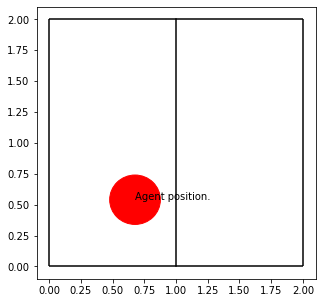

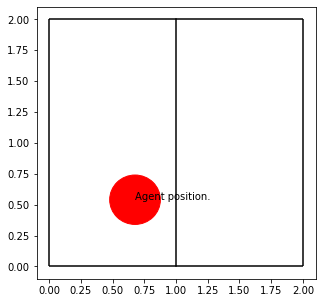

In [0]:
#@title Train affordance and transition model.
# Trains num_repeats affordance and model networks.
#@markdown Experiments to run.
run_model = True  #@param {type:"boolean"}
run_model_with_affordances = True  #@param {type:"boolean"}
num_repeats =   1#@param {type:"integer"}

#@markdown Training arguments
# use_affordance_to_mask_model = True #@param {type:"boolean"}
optimize_performance = True  #@param {type:"boolean"}
model_learning_rate = 1e-2  #@param {type:"number"}
affordance_learning_rate = 1e-1  #@param {type:"number"}
max_num_transitions = 1000  #@param {type:"integer"}
num_train_steps = 8000  #@param {type:"integer"}
affordance_mask_threshold = 0.5  #@param {type:"number"}
seed = 0  #@param {type:"integer"}
intent_threshold = 0.05  #@param {type:"number"}

#@markdown Environment arguments
drift_speed = 0.001  #@param {type:"number"}
max_action_force = 0.5  #@param {type:"number"}
movement_noise = 0.1  #@param {type:"number"}
max_episode_length = 100000  #@param {type:"integer"}

input_size = 2
action_size = 2
intent_size = len(IntentName)
hidden_nodes = 32
world_size = 2

affordance_mask_params = []
if run_model:
  affordance_mask_params.append(False)
if run_model_with_affordances:
  affordance_mask_params.append(True)

print(f'Experiments that will be run: {affordance_mask_params}')

for repeat_number in range(num_repeats):
  all_losses = {}
  model_networks = {}
  affordance_networks = {}
  new_seed = seed + repeat_number
  for use_affordance_to_mask_model in affordance_mask_params:
    print(f'Resetting seed to {new_seed}.')
    np.random.seed(new_seed)
    random.seed(new_seed)
    tf.random.set_seed(new_seed)

    affordance_network = tf.keras.Sequential([
        tf.keras.layers.Dense(
            hidden_nodes, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(
            hidden_nodes, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(
            intent_size, activation=tf.keras.activations.sigmoid),
    ])

    affordance_sgd = tf.keras.optimizers.Adam(
        learning_rate=affordance_learning_rate)
    model_sgd = tf.keras.optimizers.Adam(learning_rate=model_learning_rate)
    model_network = TransitionModel(hidden_nodes, input_size)

    # Store models for later use.
    model_networks[use_affordance_to_mask_model] = model_network
    affordance_networks[use_affordance_to_mask_model] = affordance_network

    world = ContinuousWorld(
        size=world_size,
        # Slow drift speed to make the transition from L -> R slow.
        drift_speed=drift_speed,
        drift_between=(
            # Drift between the two sides around the wall.
            Point((1 / 4) * world_size, (1 / 4) * world_size),
            Point((3 / 4) * world_size, (3 / 4) * world_size),
        ),
        max_action_force=max_action_force,
        max_episode_length=max_episode_length,
        movement_noise=movement_noise,
        wall_pairs=[
            (Point(1.0, 0.0), Point(1.0, 2.0)),
        ],
        verbose_reset=True)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)

    visualize_environment(
        world, ax, scaling=1.0, draw_start_mu=False, draw_target_mu=False)

    def _use_affordance_or_none(model):
      if use_affordance_to_mask_model:
        return model
      else:
        return None

    model_loss, aff_loss, infos = train_networks(
        world,
        model_network=model_network,
        model_optimizer=model_sgd,
        affordance_network=_use_affordance_or_none(affordance_network),
        affordance_optimizer=_use_affordance_or_none(affordance_sgd),
        print_losses=True,
        fresh_data=True,
        affordance_mask_threshold=affordance_mask_threshold,
        use_affordance_to_mask_model=use_affordance_to_mask_model,
        max_num_transitions=max_num_transitions,
        max_trajectory_length=None,
        optimize_performance=optimize_performance,
        num_train_steps=num_train_steps,
        intent_threshold=intent_threshold,
        print_every=1000)

    all_losses[use_affordance_to_mask_model] = (model_loss, aff_loss, infos)

  all_models_global.append(model_networks)
  all_affordance_global.append(affordance_networks)
  all_losses_global.append(all_losses)

In [0]:
#@title Save weights

for seed, model_networks in enumerate(all_models_global):
  model_networks[True].save_weights(
      f'./affordances/seed_{seed}_model_networks_True/keras.weights')
  model_networks[False].save_weights(
      f'./affordances/seed_{seed}_model_networks_False/keras.weights')
for seed, affordance_networks in enumerate(all_models_global):
  affordance_networks[True].save_weights(
      f'./affordances/seed_{seed}_affordance_networks_true/keras.weights')


# Visualizations


## Learning curves

In [0]:
#@title Code to collect results from a list of lists into a single array.
def _collect_results(
    all_losses_g,
    using_affordances,
    save_to_disk=False,
    smooth_weight=0.99,
    skip_first=10):
  """Collects results from the list of losses."""
  smoothed_curves = []
  for seed, trace in enumerate(all_losses_g):
    if save_to_disk:
      np.save(f'./affordances/curve_seed_{seed}_{using_affordances}.npy',
              np.array(trace[using_affordances][0]))
    # Smooth the curves for plotting.
    smoothed_curves.append(
        apply_linear_smoothing(
            trace[using_affordances][0][skip_first:], smooth_weight))
  all_curves_stacked = np.stack(smoothed_curves)
  mean_curve = np.mean(all_curves_stacked, 0)
  std_curve = np.std(all_curves_stacked, 0)
  return mean_curve, std_curve

In [0]:
#@title Plot averaged learning curves.

mean_curve_aff, std_curve_aff = _collect_results(
    all_losses_global, True)
mean_curve_normal, std_curve_normal = _collect_results(
    all_losses_global, False)
colors = ['r', 'k']
plt.plot(
    mean_curve_aff, color=colors[0], linewidth=4, label='With Affordance')
plt.plot(
    mean_curve_normal, color=colors[1], linewidth=4, label='without Affordance')

plt.fill_between(
    range(len(mean_curve_aff)),
    mean_curve_aff+std_curve_aff,
    mean_curve_aff-std_curve_aff,
    alpha=0.25,
    color=colors[0])


plt.fill_between(
    range(len(mean_curve_normal)),
    mean_curve_normal+std_curve_normal/np.sqrt(num_repeats),
    mean_curve_normal-std_curve_normal/np.sqrt(num_repeats),
    alpha=0.25,
    color=colors[1])

plt.ylim([-2.2, -1.2])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks([0, 2500, 5000, 7500],[0, 2500, 5000, 7500], fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('Updates', fontsize=20)
plt.ylabel(r'$-\log \hat{P}(s^\prime|s,a)$',fontsize=20)
plt.tight_layout()
plt.savefig('./affordances/model_learning_avg_plot.pdf')

## Intent heatmap plots

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


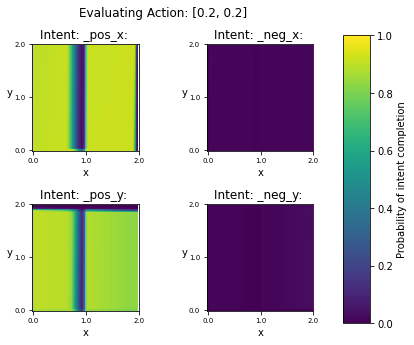

In [0]:
#@title Evaluating action and plotting intent heatmaps.
#@markdown What is the action?
action_x_dir =  0.2 #@param {type:"number"}
action_y_dir =  0.2 #@param {type:"number"}
network_seed =  0  #@param {type:"integer"}

# Cover the x-y grid.
xs = np.linspace(0, world.size)
ys = np.linspace(0, world.size)
xy_coords = tf.constant(list(itertools.product(xs, ys)), dtype=tf.float32)

eval_action = [action_x_dir, action_y_dir]
fixed_action = tf.constant([eval_action], dtype=tf.float32)
fixed_action = tf.repeat(fixed_action, 2500, axis=0)

concat_matrix = tf.concat((xy_coords, fixed_action), axis=1)
affordance_network = all_affordance_global[network_seed][True]
afford_predictions = affordance_network(concat_matrix)
affordance_predictions = tf.reshape(
    afford_predictions,
    (len(xs), len(ys), intent_size)).numpy()

plot_intents(world, affordance_predictions, eval_action)

plt.savefig(
    f'intent_eval_FX{action_x_dir}_FY{action_y_dir}.pdf', bbox_inches='tight')

## Model Predictions

In [0]:
#@title Round annotation plotting code.
ROUND_BOX = dict(boxstyle='round', facecolor='wheat', alpha=1.0)

def add_annotation(
    ax,
    start: Tuple[float, float],
    end: Tuple[float, float],
    connectionstyle, text):
  x1, y1 = start
  x2, y2 = end

  # ax.plot([x1, x2], [y1, y2], ".")
  ax.annotate(
      "",
      xy=(x1, y1),
      xycoords='data',
      xytext=(x2 + 0.25, y2),
      textcoords='data',
      size=30.0,
      arrowprops=dict(arrowstyle="->", color="0.0",
                      shrinkA=5, shrinkB=5,
                      patchA=None, patchB=None,
                      connectionstyle=connectionstyle,),)

  ax.text(*end, text, size=15,
          #transform=ax.transAxes,
          ha="left", va="top", bbox=ROUND_BOX)

connection_styles = [
  "arc3,rad=-0.3",
  "arc3,rad=0.3",
  "arc3,rad=0.0",
  "arc3,rad=0.5",
  "arc3,rad=-0.5"
]

Figures show the predicted position of the transition distribution.
Gray circle shows what would have been predicted but was masked by affordance model. 


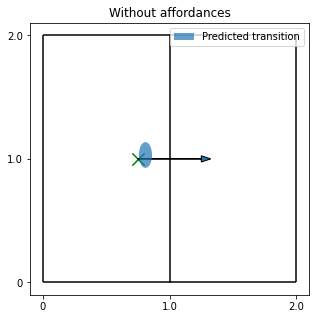

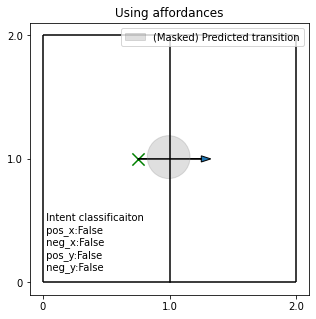

In [0]:
#@title Plotting Model predictions.

#@markdown Use affordance based model?
affordance_mask_threshold = 0.5  #@param {type:"number"}
network_seed =  0  #@param {type:"integer"}

#@markdown What is the action?
action_x_dir = +0.5  #@param {type:"number"}
action_y_dir = 0.0  #@param {type:"number"}

#@markdown Where is the agent?
agent_x = 0.75  #@param {type:"number"}
agent_y = 1.0  #@param {type:"number"}

action = tf.constant([[action_x_dir, action_y_dir]])
pos = tf.constant([[agent_x, agent_y]])

affordance_networks = all_affordance_global[network_seed]
model_networks = all_models_global[network_seed]

scale_scale = 2.0

for i, use_affordance_to_mask_model in enumerate([False, True]):
  fig = plt.figure(figsize=(5, 5))
  ax = fig.add_subplot(1, 1, 1)
  transition_dist = model_networks[use_affordance_to_mask_model](pos, action)
  transition_loc = tuple(transition_dist.loc[0].numpy())
  transition_scale = tuple(transition_dist.scale[0].numpy() * scale_scale)

  if use_affordance_to_mask_model:
    aff_network = affordance_networks[use_affordance_to_mask_model]
    AF = aff_network(tf.concat([pos, action], axis=1))
    intents_completable = (AF > affordance_mask_threshold)[0].numpy()

  visualize_environment(
      world,
      ax,
      scaling=1.0,
      draw_start_mu=False,
      draw_target_mu=False,
      draw_agent=False,
      agent_size=0.1,
      write_text=False)
  ax.scatter([agent_x], [agent_y], s=150.0, c='green', marker='x')
  ax.arrow(agent_x, agent_y, action_x_dir, action_y_dir, head_width=0.05)

  if use_affordance_to_mask_model and not np.any(intents_completable):
    color = 'gray'
    alpha = 0.25
    ellipse_text = '(Masked) '
  else:
    color = None
    alpha = 0.7
    ellipse_text = ''

  elipse = mpl.patches.Ellipse(
      transition_loc, *transition_scale, alpha=alpha, color=color)
  ax.add_artist(elipse)

  if use_affordance_to_mask_model:
    string_built = ' Intent classificaiton\n'
    for a in list(zip(IntentName, intents_completable)):
      string_built += ' ' + str(a[0])[-5:] + ':' + str(a[1])
      string_built += '\n'
    ax.text(
        0,
        0,
        string_built,
    )

  ax.set_xticks([0.0, 1.0, 2.0])
  ax.set_xticklabels([0, 1.0, 2.0])

  ax.set_yticks([0.0, 1.0, 2.0])
  ax.set_yticklabels([0, 1.0, 2.0])

  if use_affordance_to_mask_model:
    title = 'Using affordances'
  else:
    title = 'Without affordances'
  ax.set_title(title)
  ax.legend([elipse], [ellipse_text + 'Predicted transition'])
  file_name = (f'./empirical_demo{movement_noise}_P{agent_x}_{agent_y}_'
               f'F{action_x_dir}_{action_x_dir}.pdf')
  fig.savefig(file_name)

print(
    'Figures show the predicted position of the transition distribution.'
    '\nGray circle shows what would have been predicted but was masked by '
    'affordance model. ')